###**ATOC4500 Data Science Lab: Final Project**
###**Weather conditions during Boulder wildfires**
###Author: Sean Butters, sean.butters@colorado.edu###
###last updated: April 26, 2022###

**>>>> This code is available on github at (https://github.com/sbutters27/ATOC4500_Butters_FinalProject)**


###**Introduction:** Recent fires have devastated the Boulder, CO community and [cost locals millions in damages](https://www.thedenverchannel.com/news/marshall-fire/marshall-fire-destroyed-1-084-homes-damaged-149-others-for-estimated-513-million-in-losses#:~:text=Marshall%20Fire%20destroyed%201%2C084%20homes%2C%20damaged%20149%20others,estimated%20%24513%20million%20in%20losses&text=DENVER%20%E2%80%93%20The%20Marshall%20Fire%20destroyed,updated%20totals%20from%20Boulder%20County.) This [article](https://kdvr.com/news/local/nws-data-winds-of-110-115-mph-fueled-devastating-wildfire/#:~:text=BOULDER%20COUNTY%2C%20Colo.) highlights some of the uncharacteristic weather phenomena which occurred during the Marshall Fire of late 2021. This project analyzes temperature, wind speed, and relative humidity on days which wildfires occurred in Boulder, CO from 2016-2022. Data from the NCAR Mesa Laboratory (https://archive.eol.ucar.edu/cgi-bin/weather.cgi?site=ml&units=english) is utilized for analysis of the variables. Finding some significance or patterns in weather during fire days versus non-fire days could help predict future fires and inform fire policy in Boulder County. I hypothesize that temperature on fire days will not have strong significance, but there will be a tendency for fire days to have high wind speeds and low relative humidity. In laymans terms, I expect fire days to be dry and have high wind speeds.




###**Import packages**



In [1]:
import pandas as pd
#ADDED THIS: import datetime (check if I ended up using it or not)
import datetime
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files
from numpy.lib.stride_tricks import as_strided as strided
from matplotlib.pyplot import figure
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

###**Read in data**



This is data from the NCAR Mesa laboratory that has variables of pressure, temperature, relative humidity, wind direction, wind speed, max wind speed, and precipitation. The dataset I am using spans 1/1/2016 to 3/30/2022.


In [2]:
# upload data for 2016-2021 ('mesalab_2016-2021.csv') THIS ONE TAKES AWHILE SORRY :)
upload1 = files.upload()

for fn in upload1.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(upload1[fn])))#

Saving mesalab_2016-2021.csv to mesalab_2016-2021.csv
User uploaded file "mesalab_2016-2021.csv" with length 35116529 bytes


In [3]:
# upload data for 2022('mesalab_2022.csv')
upload2 = files.upload()

for fn in upload2.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(upload2[fn])))#

Saving mesalab_2022.csv to mesalab_2022.csv
User uploaded file "mesalab_2022.csv" with length 851821 bytes


In [4]:
# reading in files to dataframes

df2022tot= pd.read_csv('mesalab_2022.csv')
df2021tot= pd.read_csv('mesalab_2016-2021.csv')

###**Munge data**

The two datasets are edited and combined and a datetime index is applied for simiplicity of filtering. Some of the data is hourly, while some is taken in 5-minute increments, but all of the data is resampled using an hourly mean for this comparison. The data requires some processing to fill or interpolate missing (NaN) values. This will be done by defining and applying a linear interpolation for values that are available within 1 hour. 

In [5]:
# creating datetime series for the datasets
df2021tot['time']= pd.date_range('2016-01-01', periods=630720, freq='5Min')
df2022tot['time']= pd.date_range('2022-01-01',periods=25632,freq='5Min')

# renaming 2021 columns to match 2022
df2021tot.rename(columns={'tdry_degC':'tdry','rh_percent':'rh','wspd_m_per_s':'wspd','wspdmax_m_per_s':'wspdmax'},inplace=True)

# setting the index to the datetime series 
df2021tot.set_index('time',inplace=True)
df2022tot.set_index('time',inplace=True)

# concatenating 2021 data and 2022 data into a single dataframe 
data= pd.concat((df2021tot,df2022tot))

In [23]:
# defining a function to linearly interpolate NaN values in a series

def mask_knans(a, x): # a is series in question, x is amount of points that are acceptable to interpolate between
    a = np.asarray(a) # creating array of segment 
    k = a.size
    n = np.append(np.isnan(a), [False] * (x - 1)) # checking consecutive points
    m = np.empty(k, np.bool8)
    m.fill(True) # filling nan values with a mask

    s = n.strides[0]
    i = np.where(strided(n, (k + 1 - x, x), (s, s)).all(1))[0][:, None] # replacing masked value with average of surrounding points
    i = i + np.arange(x)
    i = pd.unique(i[i < k])

    m[i] = False

    return m

In [7]:
# applying above function to interpolate NaN values that have measurements within 1 hour

data['tdry']= data['tdry'].interpolate().where(mask_knans(data['tdry'].tolist(),12))
data['rh']= data['rh'].interpolate().where(mask_knans(data['rh'].tolist(),12))
data['wspd']= data['wspd'].interpolate().where(mask_knans(data['wspd'].tolist(),12))
data['wspdmax']= data['wspdmax'].interpolate().where(mask_knans(data['wspdmax'].tolist(),12))

In [8]:
# resampling dataset using hourly mean for each variable
tdry= data['tdry'].resample('1H').mean()
rh= data['rh'].resample('1H').mean()
wspd= data['wspd'].resample('1H').mean()
wspdmax= data['wspdmax'].resample('1H').mean()

data=pd.concat((tdry,rh,wspd,wspdmax),axis=1)

In [9]:
# making a column 'fire' in the dataframe (0 for no fire, 1 for fire)

# filling column initially with zeros
data['fire']=len(data)*[0]

# Setting fire values from  July 9-12, 2016 to 1 (Cold Springs Fire)
data.loc[(data.index>= '2016-07-09') & (data.index<='2016-07-12'),['fire']]=1

# Setting fire values from October 17-November 5, 2020 to 1 (CalWood and Left Hand Fire)
data.loc[(data.index>= '2020-10-17') & (data.index<='2020-11-05'),['fire']]=1

# Setting fire values from December 30, 2021-January 1, 2022 to 1 (Marshall Fire)
data.loc[(data.index>= '2021-12-30') & (data.index<='2022-01-01'),['fire']]=1

# Setting fire values from March 26-27, 2022 to 1 (NCAR fire)
data.loc[(data.index>= '2022-03-26') & (data.index<='2022-03-27'),['fire']]=1

# Creating a separate dataframe for only fire days
firedata=data[data.fire==1]

###**Apply Data Science Method**

The data science method applied here is the creation of a 95 percent confidence interval (+/- 2*SD) for the dataset where temperature, relative humidity, and wind speed should fall. This will be used in the plots to visualize whether these variables tend to fall outside the confidence interval on days where fire occured. The means and standard deviations are shown below.

In [10]:
# calculating basic statistics for entire dataset

print('temperature mean (deg C):',data.tdry.mean())
print('temperature standard deviation:',data.tdry.std())
print('\n')
print('relative humidity mean (%):',data.rh.mean())
print('relative humidity standard deviation:',data.rh.std())
print('\n')
print('wind speed mean (m/s):',data.wspd.mean())
print('wind speed standard deviation:',data.wspd.std())

temperature mean (deg C): 10.759370785909523
temperature standard deviation: 10.207593325549512


relative humidity mean (%): 41.56036168364574
relative humidity standard deviation: 22.830234052289676


wind speed mean (m/s): 3.4444861188234324
wind speed standard deviation: 2.3186353084964626


In [11]:
# calculating statistics for fire days

print('temperature mean (deg C):',firedata.tdry.mean())
print('temperature standard deviation:',data.tdry.std())
print('\n')
print('relative humidity mean (%):',firedata.rh.mean())
print('relative humidity standard deviation:',firedata.rh.std())
print('\n')
print('wind speed mean (m/s):',firedata.wspd.mean())
print('wind speed standard deviation:',firedata.wspd.std())

temperature mean (deg C): 10.089568341059353
temperature standard deviation: 10.207593325549512


relative humidity mean (%): 39.52176256527304
relative humidity standard deviation: 24.38873818226793


wind speed mean (m/s): 3.5101169046620186
wind speed standard deviation: 2.1036476148140317


###**Present results visually using 2-3 graphs**

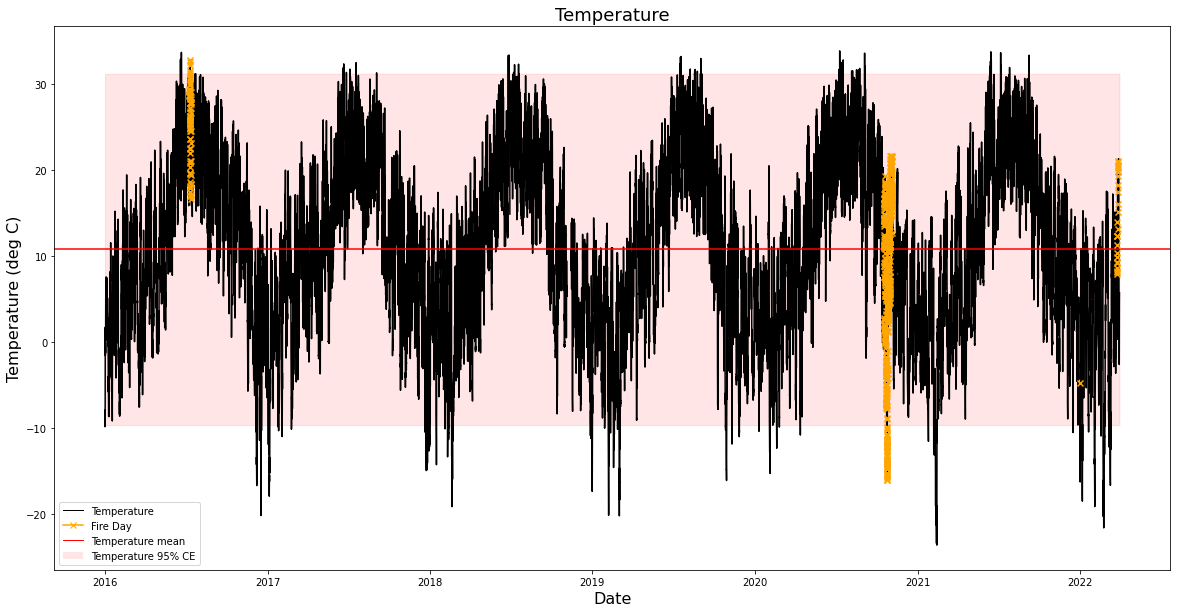

In [27]:
figure(figsize=(20,10))
plt.plot(data.tdry,color='k')
plt.ylabel('Temperature (deg C)',fontsize=16)
plt.xlabel('Date',fontsize=16)
plt.axhline(y=data.tdry.mean(),color='r')
plt.fill_between(data.index,data.tdry.mean()-2*data.tdry.std(), data.tdry.mean()+2*data.tdry.std(),color='r',alpha=0.1)
plt.scatter(firedata.index, firedata.tdry,color='orange',marker='x',zorder=3)
legend_elts= [Line2D([0],[0],color='k',lw=1,label='Temperature'),
              Line2D([0],[0],marker='x',color='orange',label='Fire Day'),
              Line2D([0],[0],color='r',lw=1,label='Temperature mean'),
              Patch(facecolor='r',alpha=0.1,label='Temperature 95% CE')]
plt.legend(handles=legend_elts)
plt.title('Temperature',fontsize=18)
plt.show()

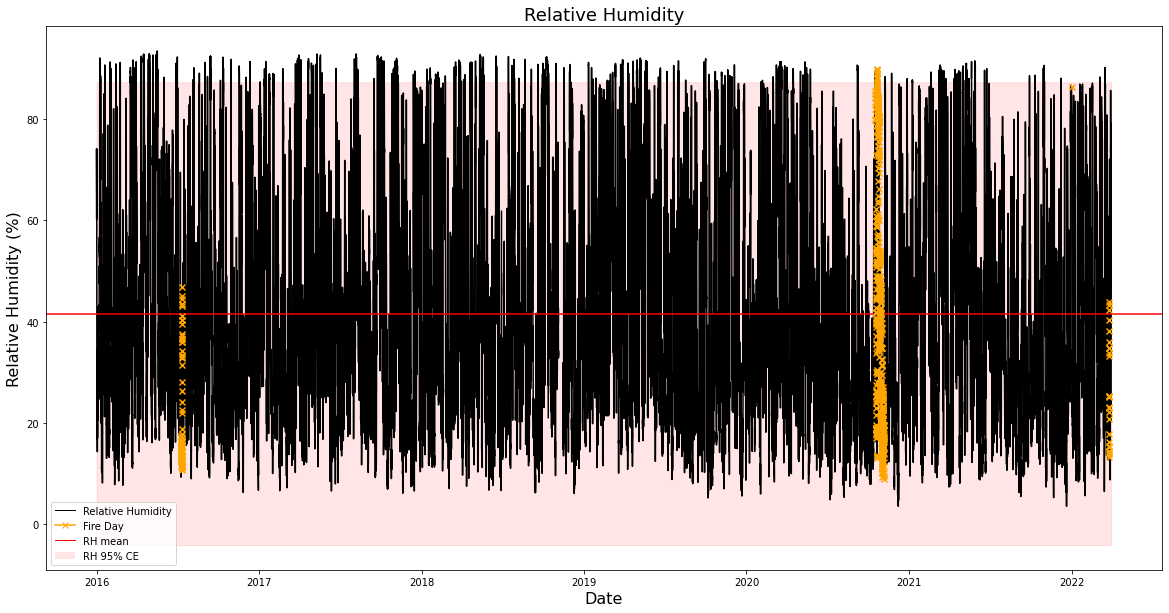

In [28]:
figure(figsize=(20,10))
plt.plot(data.rh,color='k')
plt.ylabel('Relative Humidity (%)',fontsize=16)
plt.xlabel('Date',fontsize=16)
plt.axhline(y=data.rh.mean(),color='r')
plt.fill_between(data.index,data.rh.mean()-2*data.rh.std(), data.rh.mean()+2*data.rh.std(),color='r',alpha=0.1)
plt.scatter(firedata.index, firedata.rh,color='orange',marker='x',zorder=3)
legend_elts= [Line2D([0],[0],color='k',lw=1,label='Relative Humidity'),
              Line2D([0],[0],marker='x',color='orange',label='Fire Day'),
              Line2D([0],[0],color='r',lw=1,label='RH mean'),
              Patch(facecolor='r',alpha=0.1,label='RH 95% CE')]
plt.legend(handles=legend_elts)
plt.title('Relative Humidity',fontsize=18)
plt.show()

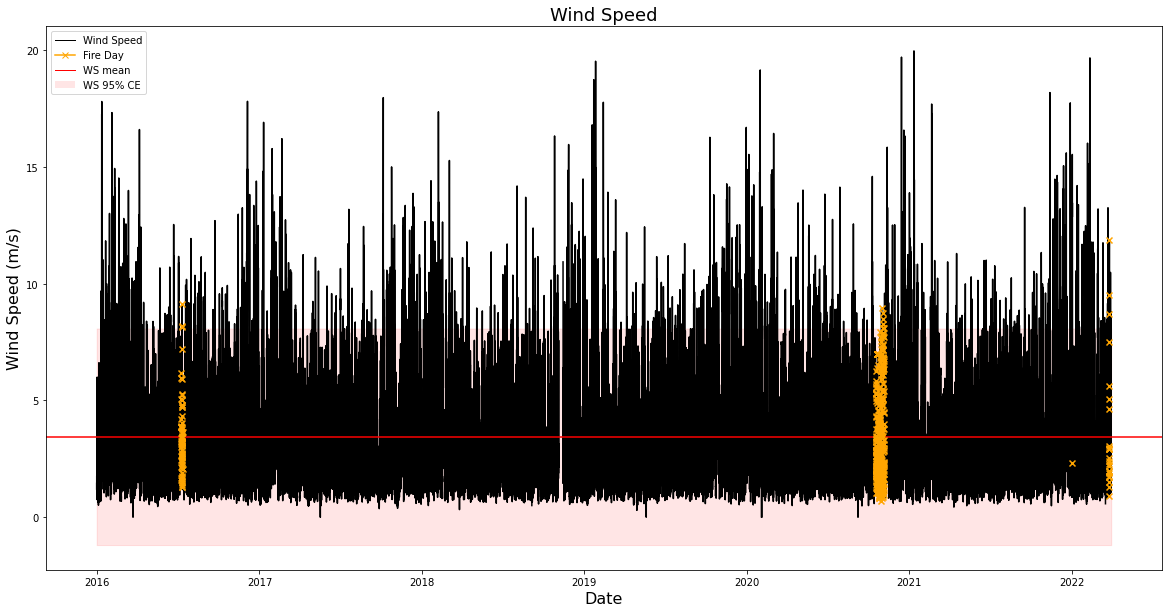

In [29]:
figure(figsize=(20,10))
plt.plot(data.wspd,color='k')
plt.ylabel('Wind Speed (m/s)',fontsize=16)
plt.xlabel('Date',fontsize=16)
plt.axhline(y=data.wspd.mean(),color='r')
plt.fill_between(data.index,data.wspd.mean()-2*data.wspd.std(), data.wspd.mean()+2*data.wspd.std(),color='r',alpha=0.1)
plt.scatter(firedata.index, firedata.wspd,color='orange',marker='x',zorder=3)
legend_elts= [Line2D([0],[0],color='k',lw=1,label='Wind Speed'),
              Line2D([0],[0],marker='x',color='orange',label='Fire Day'),
              Line2D([0],[0],color='r',lw=1,label='WS mean'),
              Patch(facecolor='r',alpha=0.1,label='WS 95% CE')]
plt.legend(handles=legend_elts)
plt.title('Wind Speed',fontsize=18)
plt.show()

Text(0.5, 1.0, 'WSPD')

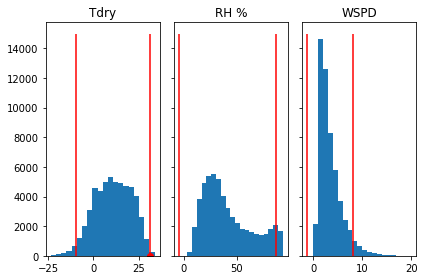

In [15]:
#plots histogram for the variables and vertical lines for +/- 2 standard deviations (i.e. 95%)
fig, axs = plt.subplots(1, 3, sharey=True, tight_layout=True)
axs[0].hist(data.tdry, bins=20)
axs[0].plot(data.tdry.mean()+2*data.tdry.std(), 0 ,color='red', marker='o')
axs[0].vlines(data.tdry.mean()+2*data.tdry.std(),0,15000,color='red')
axs[0].vlines(data.tdry.mean()-2*data.tdry.std(),0,15000,color='red')
axs[0].set_title('Tdry')

axs[1].hist(data.rh, bins=20)
axs[1].vlines(data.rh.mean()+2*data.rh.std(),0,15000,color='red')
axs[1].vlines(data.rh.mean()-2*data.rh.std(),0,15000,color='red')
axs[1].set_title('RH %')

axs[2].hist(data.wspd, bins=20)
axs[2].vlines(data.wspd.mean()+2*data.wspd.std(),0,15000,color='red')
axs[2].vlines(data.wspd.mean()-2*data.wspd.std(),0,15000,color='red')
axs[2].set_title('WSPD')

In [16]:
#does the data outside the 95% correspond to days with fire? 
#tdry_out95_all has 1 conditions: tdry must be outside the 95% confidence
tdry_out95_all = data.tdry[(data.tdry > data.tdry.mean()+2*data.tdry.std()) & (data.tdry > data.tdry.mean()-2*data.tdry.std())]
#t_dry_out95_fire: same as above but only fire days:
tdry_out95_fire = data.tdry[(data.tdry > data.tdry.mean()+2*data.tdry.std()) & (data.tdry > data.tdry.mean()-2*data.tdry.std()) & data.fire==1]
#what is the percent of days outside 95% confidence that have a fire
tdry_percent_out_95_with_fire = len(tdry_out95_fire)/len(tdry_out95_all) *100
print('% of days with fire with tdry outside 95%:', tdry_percent_out_95_with_fire)

% of days with fire with tdry outside 95%: 2.793296089385475


In [17]:
rh_out95_all = data.rh[(data.rh > data.rh.mean()+2*data.rh.std()) & (data.rh > data.rh.mean()-2*data.rh.std())]
#t_dry_out95_fire: same as above but only fire days:
rh_out95_fire = data.rh[(data.rh > data.rh.mean()+2*data.rh.std()) & (data.rh > data.rh.mean()-2*data.rh.std()) & data.fire==1]
#what is the percent of days outside 95% confidence that have a fire
rh_percent_out_95_with_fire = len(rh_out95_fire)/len(rh_out95_all) *100
print('% of days with fire with RH outside 95%:',rh_percent_out_95_with_fire)

% of days with fire with RH outside 95%: 0.36689767631471665


In [18]:
wspd_out95_all = data.wspd[(data.wspd > data.wspd.mean()+2*data.wspd.std()) & (data.wspd > data.wspd.mean()-2*data.wspd.std())]
#t_dry_out95_fire: same as above but only fire days:
wspd_out95_fire = data.wspd[(data.wspd > data.wspd.mean()+2*data.wspd.std()) & (data.wspd > data.wspd.mean()-2*data.wspd.std()) & data.fire==1]
#what is the percent of days outside 95% confidence that have a fire
wspd_percent_out_95_with_fire = len(wspd_out95_fire)/len(wspd_out95_all) *100
print('% of days with fire with WSPD outside 95%:',wspd_percent_out_95_with_fire)

% of days with fire with WSPD outside 95%: 0.4931714719271623


In [19]:
#what we know from this is that of the days with t, rh, wspd outside the 95% confidence, only 2.8%, 0.4% and 0.5% (respectively) of the days correspond to days with fires
#we could tackle this from a different approach: same analysis but instead of looking at the whole time series for the calculations we do it only for the days with fires,
# so if January 1st 2018 has a fire, the we get the mean and sdv for temperature for all the january 1st's in the time series, and see where the value for that particular day falls.
#this is kind of similar to the type of statistics for meteorology and daily temperatures... we are basically asking for a fire in january 1st, 2018, where the conditions outside the 95% 
#confidence for the conditions on all januarys 1st's on record
#1)calculate the mean and sdv by day of year (should yield 365 values):
data_new_mean = data.groupby([data.index.month, data.index.day]).mean()
data_new_sdv = data.groupby([data.index.month, data.index.day]).std()
#create a column with the value of day of years (i.e. 1-365) (by using the pd.period function we account automatically for leap years)
doy=[np.nan for x in range(len(firedata))]
for i in range(0,604):
  test=pd.Period(firedata.index[i],freq='H')
  doy[i]=test.day_of_year
#insert doy column to our data
firedata.insert(0,'doy',doy)
#firedata is still in hourly timesteps, lets get a mean for each day with fire:
new_firedata = firedata.groupby([firedata.index.month, firedata.index.day]).mean()



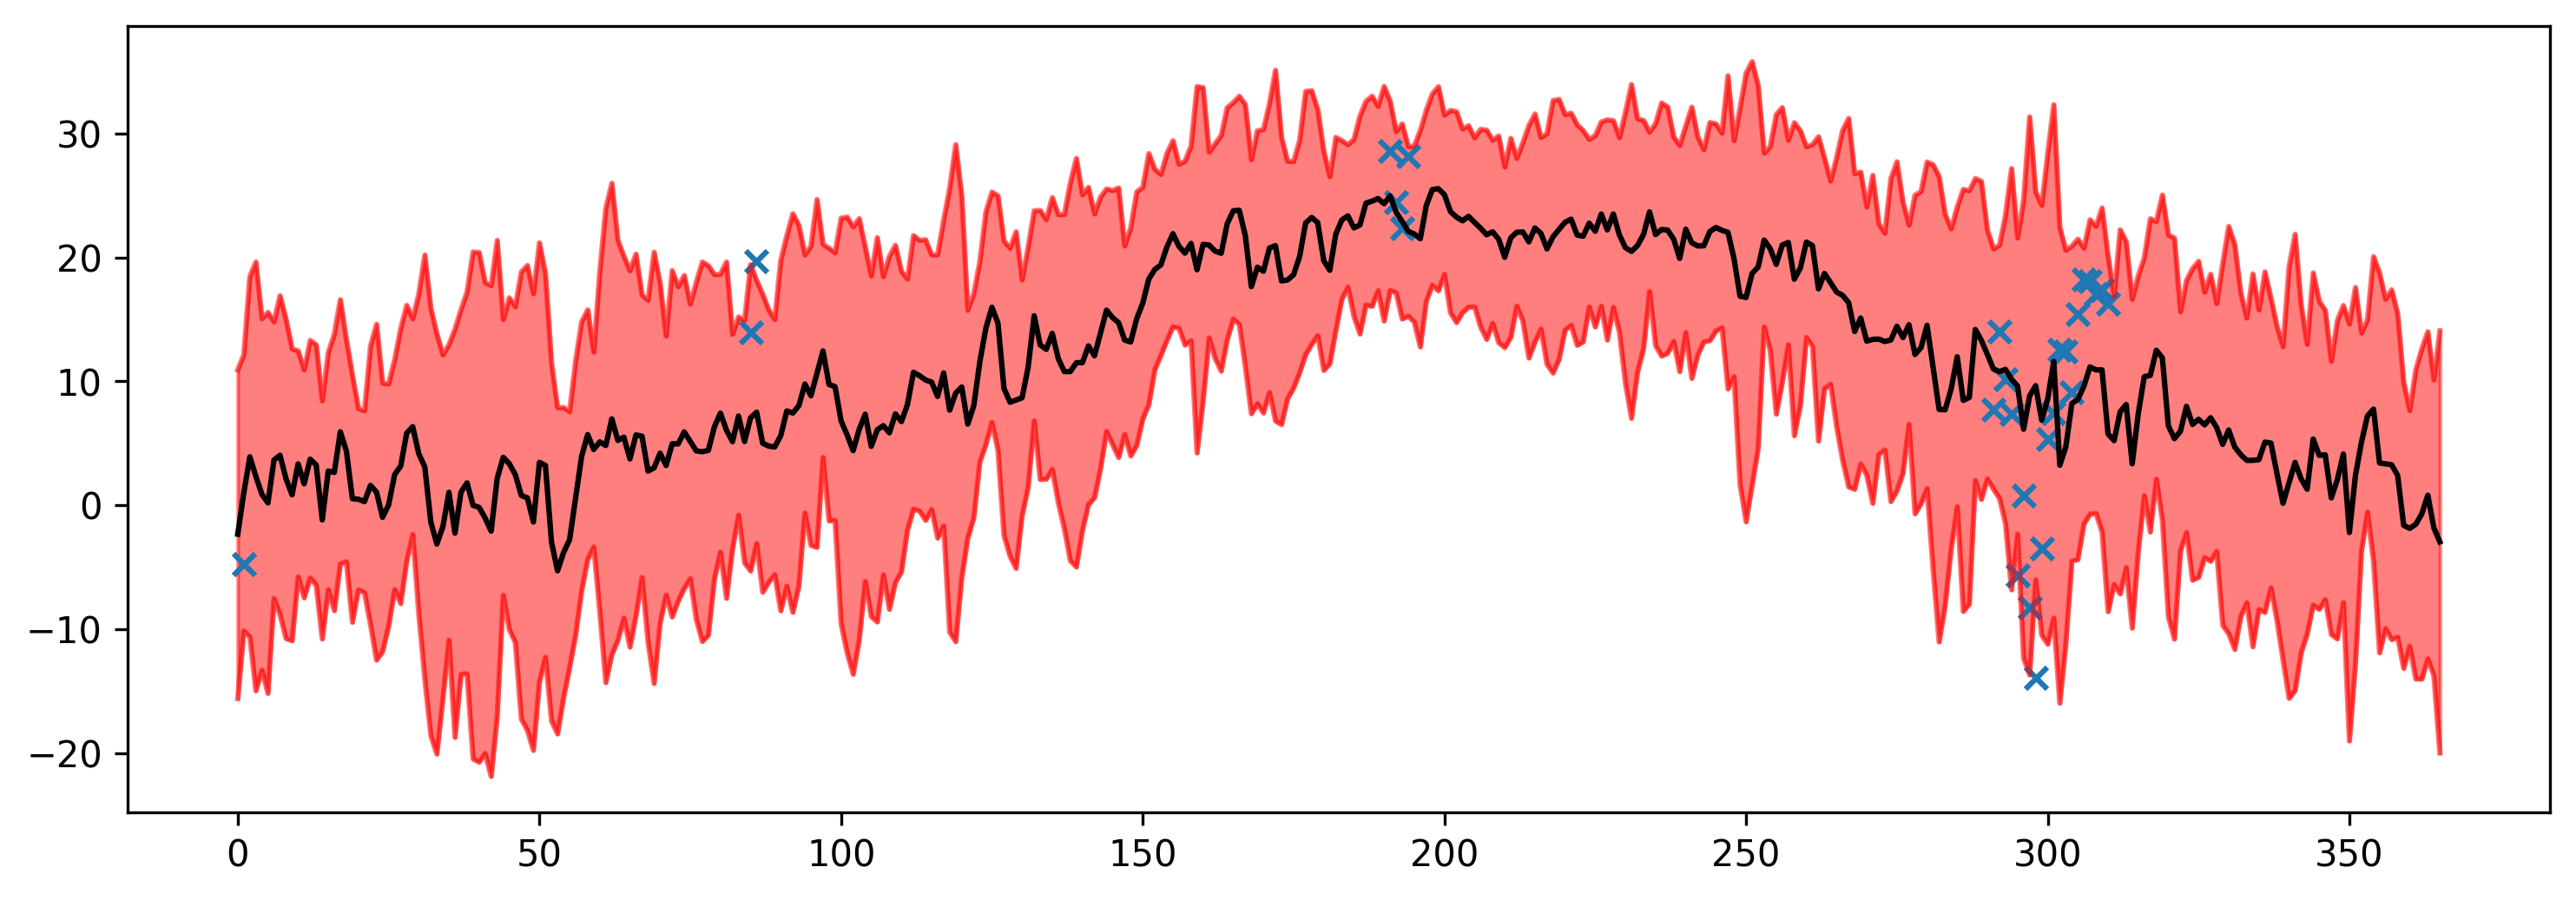

In [20]:
figure(figsize=(12, 4), dpi=300)
plt.plot(data_new_mean.tdry.values,'k')
plt.plot(data_new_mean.tdry.values + 2*data_new_sdv.tdry.values,'r',alpha=0.5)
plt.plot(data_new_mean.tdry.values - 2*data_new_sdv.tdry.values,'r',alpha=0.5)
plt.fill_between(np.linspace(0, 365, 366, endpoint=True),data_new_mean.tdry.values - 2*data_new_sdv.tdry.values, data_new_mean.tdry.values + 2*data_new_sdv.tdry.values,color='red',alpha=0.5)
plt.scatter(new_firedata.doy,new_firedata.tdry,marker='x')
plt.show()

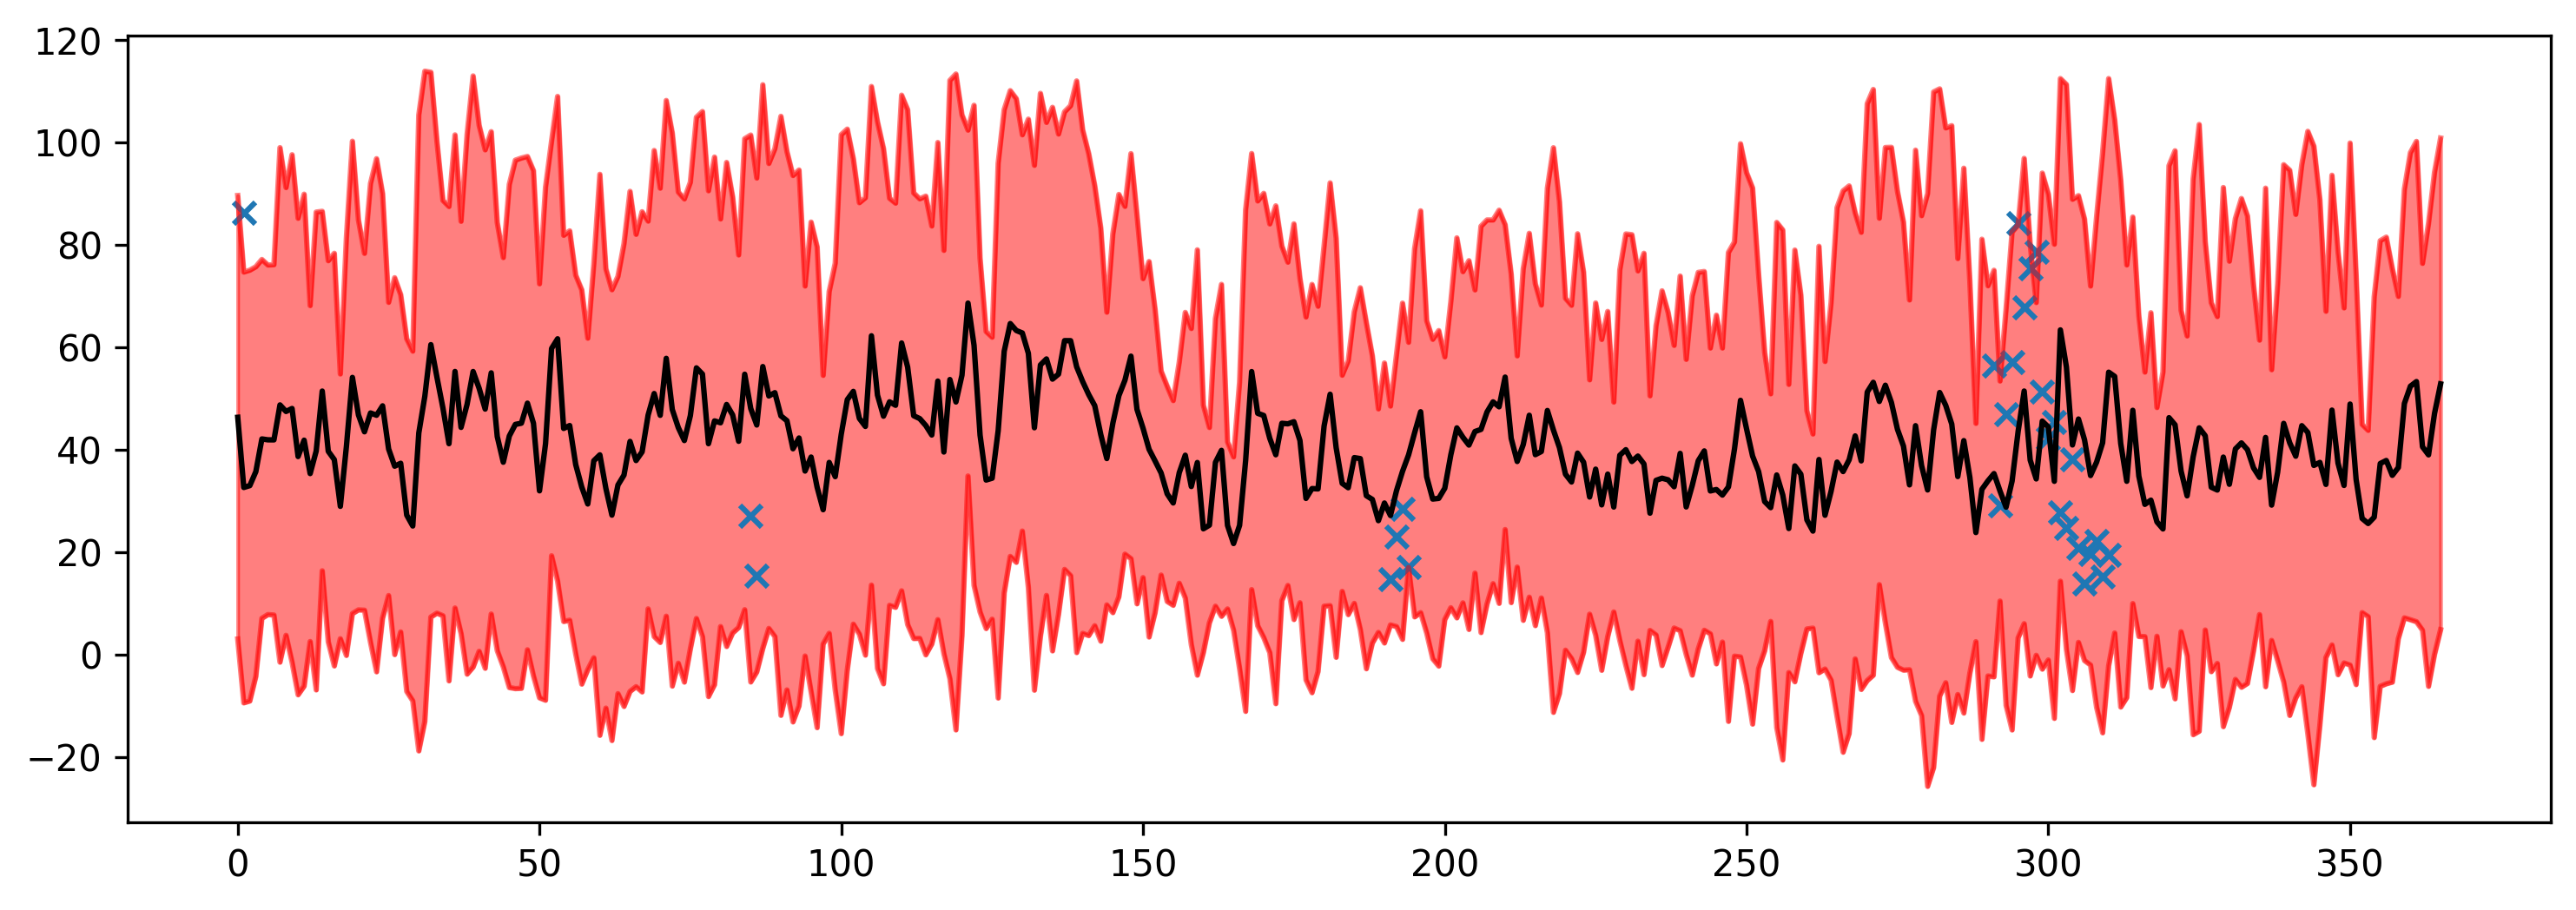

In [21]:
figure(figsize=(12, 4), dpi=300)
plt.plot(data_new_mean.rh.values,'k')
plt.plot(data_new_mean.rh.values + 2*data_new_sdv.rh.values,'r',alpha=0.5)
plt.plot(data_new_mean.rh.values - 2*data_new_sdv.rh.values,'r',alpha=0.5)
plt.fill_between(np.linspace(0, 365, 366, endpoint=True),data_new_mean.rh.values - 2*data_new_sdv.rh.values, data_new_mean.rh.values + 2*data_new_sdv.rh.values,color='red',alpha=0.5)
plt.scatter(new_firedata.doy,new_firedata.rh,marker='x')
plt.show()

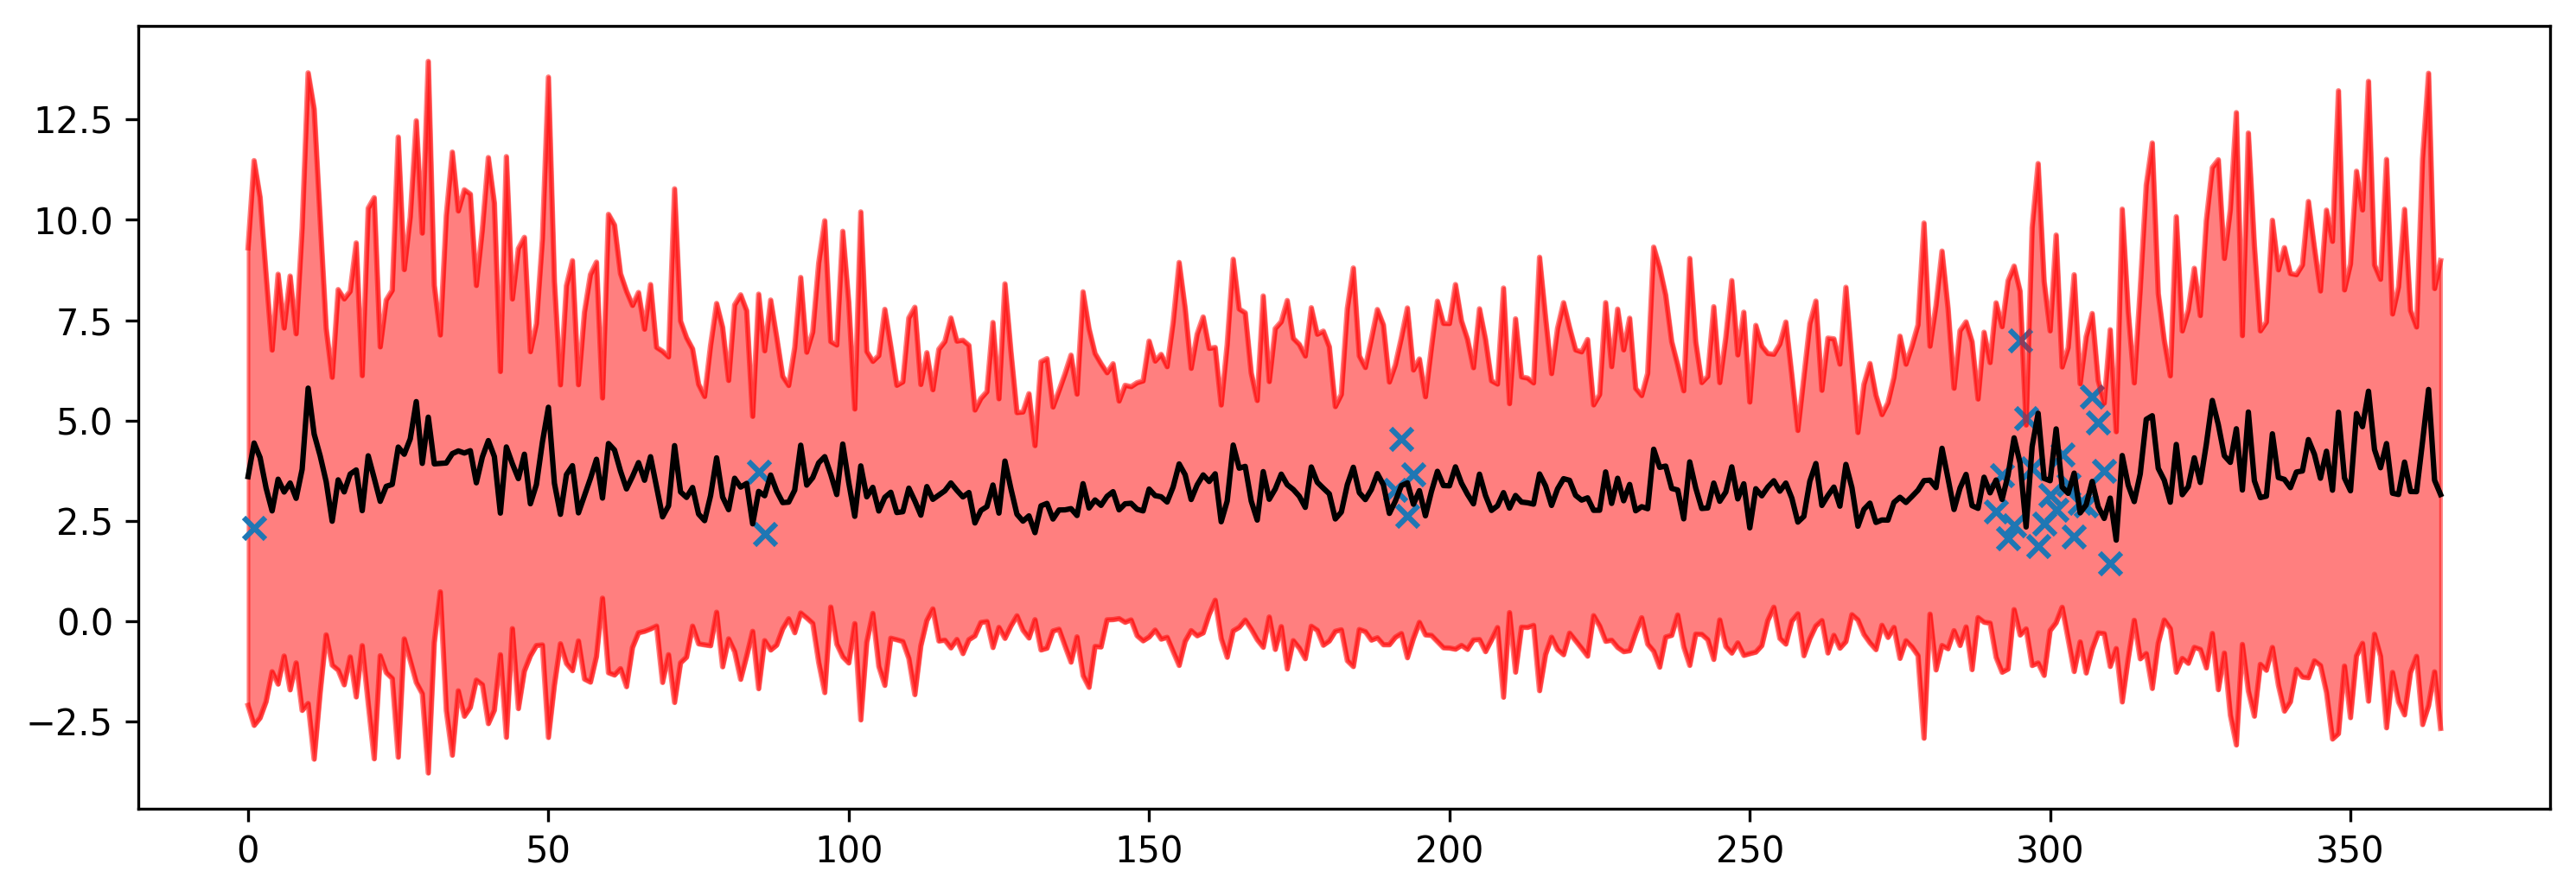

In [22]:
figure(figsize=(12, 4), dpi=300)
plt.plot(data_new_mean.wspd.values,'k')
plt.plot(data_new_mean.wspd.values + 2*data_new_sdv.wspd.values,'r',alpha=0.5)
plt.plot(data_new_mean.wspd.values - 2*data_new_sdv.wspd.values,'r',alpha=0.5)
plt.fill_between(np.linspace(0, 365, 366, endpoint=True),data_new_mean.wspd.values - 2*data_new_sdv.wspd.values, data_new_mean.wspd.values + 2*data_new_sdv.wspd.values,color='red',alpha=0.5)
plt.scatter(new_firedata.doy,new_firedata.wspd,marker='x')
plt.show()

both analysis added agree with my suspicions: there is not a clear indication that T, RH or WSPD where siginificantly different during fire days, we compared this against the full time series and by day of year. Note: we have very few days with fires, the day of year analysis may be better suited to account for this limitation. Another way to approach this analysis is by dividing in seasons or months. Also it seems that the fire database did not include the Louisville/Marshall fire? I dont see fire days on december 2021. Which could've potentially been one of the few exceptions. maybe.

Also, both the histograms and the cells where I estimate the % of fire days outside the 95% interval do not account for your data still being in hourly format (i.e. what is calculated is actually %percent of hours with fires outside the 95% confidence). You can easily fix that by doing the groupby command that I used later on... before histogram do something like data=data.groupby([data.index.month, data.index.day]).mean()....it may actually change the histograms and the percents a little bit and give you higher percents. 

###**Summary**: The plots above generally support my initial hypothesis. Temperature does not have a significant difference from expected on days when fire occurred. There are some fires that occurred during higher than average temperatures, and others that occurred during lower than average temperatures. For all instances of fire in the time interval, most of the temperatures were within the 95 perecent confidence interval. For relative humidity, as expected, most fire did occur during times when relative humidity was below average. Yet these values were still within the 95 percent confidence range and there were no specific instances of dryness that correlated with fire days. Finally, for wind speed, days with fire did line up with wind speed spikes. This was perhaps the most significant variable visually, and it makes sense for locals of Boulder who have experienced recent fires and intense winds.

###**References**: 

1.   https://www.thedenverchannel.com/news/marshall-fire/marshall-fire-destroyed-1-084-homes-damaged-149-others-for-estimated-513-million-in-losses#:~:text=Marshall%20Fire%20destroyed%201%2C084%20homes%2C%20damaged%20149%20others,estimated%20%24513%20million%20in%20losses&text=DENVER%20%E2%80%93%20The%20Marshall%20Fire%20destroyed,updated%20totals%20from%20Boulder%20County.
2.   https://kdvr.com/news/local/nws-data-winds-of-110-115-mph-fueled-devastating-wildfire/#:~:text=BOULDER%20COUNTY%2C%20Colo.
3. https://archive.eol.ucar.edu/cgi-bin/weather.cgi?site=ml&units=english



